Epoch 1/50, MSE: 1.0436
Epoch 2/50, MSE: 1.0000
Epoch 3/50, MSE: 0.9592
Epoch 4/50, MSE: 0.9208
Epoch 5/50, MSE: 0.8847
Epoch 6/50, MSE: 0.8509
Epoch 7/50, MSE: 0.8191
Epoch 8/50, MSE: 0.7893
Epoch 9/50, MSE: 0.7613
Epoch 10/50, MSE: 0.7349
Epoch 11/50, MSE: 0.7102
Epoch 12/50, MSE: 0.6870
Epoch 13/50, MSE: 0.6653
Epoch 14/50, MSE: 0.6448
Epoch 15/50, MSE: 0.6256
Epoch 16/50, MSE: 0.6075
Epoch 17/50, MSE: 0.5906
Epoch 18/50, MSE: 0.5747
Epoch 19/50, MSE: 0.5598
Epoch 20/50, MSE: 0.5457
Epoch 21/50, MSE: 0.5325
Epoch 22/50, MSE: 0.5202
Epoch 23/50, MSE: 0.5086
Epoch 24/50, MSE: 0.4976
Epoch 25/50, MSE: 0.4874
Epoch 26/50, MSE: 0.4778
Epoch 27/50, MSE: 0.4687
Epoch 28/50, MSE: 0.4602
Epoch 29/50, MSE: 0.4522
Epoch 30/50, MSE: 0.4447
Epoch 31/50, MSE: 0.4377
Epoch 32/50, MSE: 0.4311
Epoch 33/50, MSE: 0.4249
Epoch 34/50, MSE: 0.4190
Epoch 35/50, MSE: 0.4135
Epoch 36/50, MSE: 0.4084
Epoch 37/50, MSE: 0.4036
Epoch 38/50, MSE: 0.3990
Epoch 39/50, MSE: 0.3947
Epoch 40/50, MSE: 0.3907
Epoch 41/

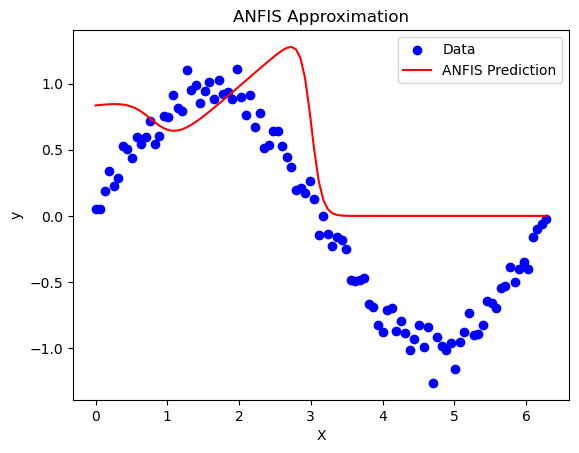

In [3]:
import numpy as np
import itertools

class MembershipFunction:
    """
    Gaussian membership function:
       μ(x; c, σ) = exp(-0.5 * ((x - c)/σ)^2)
    """
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

    def evaluate(self, x):
        return np.exp(-0.5 * ((x - self.mean) / self.sigma) ** 2)

    def update_parameters(self, d_mean, d_sigma, lr):
        self.mean -= lr * d_mean
        self.sigma -= lr * d_sigma

class ANFIS:
    def __init__(self, n_inputs, n_mfs):
        """
        n_inputs: number of input variables.
        n_mfs: number of membership functions per input.
        """
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        
        # Initialize membership functions for each input
        # Each input will have 'n_mfs' Gaussian membership functions with random parameters.
        self.mfs = []
        for i in range(n_inputs):
            # For reproducibility, you might want to set a random seed.
            mfs_for_input = [MembershipFunction(mean=np.random.uniform(0, 1), 
                                                  sigma=np.random.uniform(0.1, 1)) 
                             for _ in range(n_mfs)]
            self.mfs.append(mfs_for_input)
        
        # Create rule base: each rule is a combination of one membership function per input.
        self.rules = list(itertools.product(range(n_mfs), repeat=n_inputs))
        self.n_rules = len(self.rules)
        
        # Initialize consequent parameters for each rule.
        # For each rule, we use a first-order linear function: f = p1*x1 + p2*x2 + ... + pn*xn + r.
        # So for each rule, there are (n_inputs + 1) parameters.
        self.consequents = np.random.rand(self.n_rules, n_inputs + 1)

    def forward(self, X):
        """
        Forward pass:
          X: input data of shape (n_samples, n_inputs)
          
        Returns:
          output: final predicted output of shape (n_samples,)
          firing_strengths: (n_samples, n_rules) before normalization
          normalized_fs: normalized firing strengths
          rule_outputs: each rule's output before aggregation
        """
        n_samples = X.shape[0]
        
        # Layer 1: Evaluate membership function outputs for each input.
        mf_outputs = []
        for i in range(self.n_inputs):
            x = X[:, i]
            outputs = np.zeros((n_samples, self.n_mfs))
            for j in range(self.n_mfs):
                outputs[:, j] = self.mfs[i][j].evaluate(x)
            mf_outputs.append(outputs)
        
        # Layer 2: Compute firing strengths for each rule by taking the product 
        # of the corresponding membership values for each input.
        firing_strengths = np.zeros((n_samples, self.n_rules))
        for r, rule in enumerate(self.rules):
            prod = np.ones(n_samples)
            for i, mf_index in enumerate(rule):
                prod *= mf_outputs[i][:, mf_index]
            firing_strengths[:, r] = prod
        
        # Layer 3: Normalize the firing strengths.
        sum_fs = np.sum(firing_strengths, axis=1, keepdims=True)
        normalized_fs = firing_strengths / (sum_fs + 1e-6)  # add epsilon to avoid division by zero
        
        # Layer 4: Compute each rule's output.
        rule_outputs = np.zeros((n_samples, self.n_rules))
        for r in range(self.n_rules):
            # Linear function: f = (p1*x1 + p2*x2 + ... + pn*xn + r)
            params = self.consequents[r]
            rule_outputs[:, r] = np.dot(X, params[:-1]) + params[-1]
        
        # Layer 5: Aggregate rule outputs weighted by the normalized firing strengths.
        output = np.sum(normalized_fs * rule_outputs, axis=1)
        
        return output, firing_strengths, normalized_fs, rule_outputs

    def train(self, X, y, epochs=10, lr=0.01):
        """
        A simplified training routine using gradient descent for the consequent parameters.
        Note: A complete ANFIS training typically uses a hybrid learning algorithm:
              - Least squares estimation (LSE) for the consequent parameters.
              - Gradient descent (backpropagation) for the premise parameters.
        In this demo, we update the consequent parameters using gradient descent
        and leave the premise parameter updates as a placeholder.
        """
        n_samples = X.shape[0]
        for epoch in range(epochs):
            # Forward pass
            output, firing_strengths, normalized_fs, rule_outputs = self.forward(X)
            
            # Compute error and mean squared error (MSE)
            error = y - output
            mse = np.mean(error ** 2)
            print(f"Epoch {epoch+1}/{epochs}, MSE: {mse:.4f}")
            
            # Update consequent parameters via gradient descent.
            # The gradient of the error with respect to the consequent parameters for rule r is:
            # dE/dtheta_r = -2 * normalized_fs[:, r] * error * [x1, x2, ..., xn, 1]
            grad_consequents = np.zeros_like(self.consequents)
            for r in range(self.n_rules):
                grad = -2 * normalized_fs[:, r][:, None] * error[:, None] * np.hstack((X, np.ones((n_samples, 1))))
                grad_consequents[r] = np.mean(grad, axis=0)
            self.consequents -= lr * grad_consequents
            
            # Placeholder for updating premise parameters (membership function parameters).
            # A full implementation would compute the derivative of the error with respect to
            # each membership function parameter (mean and sigma) using the chain rule.
            # For brevity, we skip these updates in this simple demo.
            
        print("Training complete.")

    def predict(self, X):
        output, *_ = self.forward(X)
        return output

# Example usage:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Generate sample data: approximating y = sin(x) with noise.
    np.random.seed(42)
    X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
    y = np.sin(X).ravel() + 0.1 * np.random.randn(100)

    # Create an ANFIS model for 1 input and 3 membership functions per input.
    anfis_model = ANFIS(n_inputs=1, n_mfs=3)
    
    # Train the model.
    anfis_model.train(X, y, epochs=50, lr=0.01)
    
    # Make predictions.
    y_pred = anfis_model.predict(X)
    
    # Plot the original data and ANFIS predictions.
    plt.scatter(X, y, label="Data", color='blue')
    plt.plot(X, y_pred, label="ANFIS Prediction", color='red')
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.title("ANFIS Approximation")
    plt.show()


In [4]:
import numpy as np
import itertools
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class MembershipFunction:
    """
    Gaussian membership function:
      μ(x; c, σ) = exp(-0.5 * ((x - c)/σ)^2)
    """
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

    def evaluate(self, x):
        return np.exp(-0.5 * ((x - self.mean) / self.sigma) ** 2)

    def update_parameters(self, d_mean, d_sigma, lr):
        self.mean -= lr * d_mean
        self.sigma -= lr * d_sigma

class ANFIS:
    def __init__(self, n_inputs, n_mfs, n_outputs):
        """
        n_inputs: number of input features.
        n_mfs: number of membership functions per input.
        n_outputs: number of output dimensions (for classification, number of classes).
        """
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.n_outputs = n_outputs
        
        # Initialize membership functions for each input.
        self.mfs = []
        for i in range(n_inputs):
            mfs_for_input = [MembershipFunction(mean=np.random.uniform(0, 1),
                                                sigma=np.random.uniform(0.1, 1))
                             for _ in range(n_mfs)]
            self.mfs.append(mfs_for_input)
        
        # Create rule base: each rule is a combination of one membership function per input.
        self.rules = list(itertools.product(range(n_mfs), repeat=n_inputs))
        self.n_rules = len(self.rules)
        
        # Initialize consequent parameters for each rule.
        # For each rule, we use a first-order linear function with n_inputs features plus bias.
        # Now each consequent is a matrix of shape (n_inputs + 1, n_outputs).
        self.consequents = np.random.rand(self.n_rules, n_inputs + 1, n_outputs)

    def forward(self, X):
        """
        Forward pass:
          X: input data of shape (n_samples, n_inputs)
        Returns:
          output: final predicted output of shape (n_samples, n_outputs)
          firing_strengths: (n_samples, n_rules) before normalization
          normalized_fs: normalized firing strengths
          rule_outputs: each rule's output before aggregation (n_samples, n_rules, n_outputs)
        """
        n_samples = X.shape[0]
        
        # Layer 1: Evaluate membership function outputs for each input.
        mf_outputs = []
        for i in range(self.n_inputs):
            x = X[:, i]
            outputs = np.zeros((n_samples, self.n_mfs))
            for j in range(self.n_mfs):
                outputs[:, j] = self.mfs[i][j].evaluate(x)
            mf_outputs.append(outputs)
        
        # Layer 2: Compute firing strengths for each rule by taking the product 
        # of the corresponding membership values for each input.
        firing_strengths = np.zeros((n_samples, self.n_rules))
        for r, rule in enumerate(self.rules):
            prod = np.ones(n_samples)
            for i, mf_index in enumerate(rule):
                prod *= mf_outputs[i][:, mf_index]
            firing_strengths[:, r] = prod
        
        # Layer 3: Normalize the firing strengths.
        sum_fs = np.sum(firing_strengths, axis=1, keepdims=True)
        normalized_fs = firing_strengths / (sum_fs + 1e-6)
        
        # Prepare augmented input X: add a bias term (1).
        X_aug = np.hstack((X, np.ones((n_samples, 1))))
        
        # Layer 4: Compute each rule's output.
        # Each rule has consequent parameters of shape (n_inputs+1, n_outputs).
        rule_outputs = np.zeros((n_samples, self.n_rules, self.n_outputs))
        for r in range(self.n_rules):
            # For each rule, compute linear output: f = X_aug dot consequent parameters.
            rule_outputs[:, r, :] = np.dot(X_aug, self.consequents[r])
        
        # Layer 5: Aggregate rule outputs weighted by the normalized firing strengths.
        output = np.sum(normalized_fs[:, :, None] * rule_outputs, axis=1)
        
        return output, firing_strengths, normalized_fs, rule_outputs

    def train(self, X, y, epochs=10, lr=0.01):
        """
        Training routine using gradient descent to update the consequent parameters.
        y: one-hot encoded targets of shape (n_samples, n_outputs)
        """
        n_samples = X.shape[0]
        X_aug = np.hstack((X, np.ones((n_samples, 1))))
        
        for epoch in range(epochs):
            # Forward pass.
            output, firing_strengths, normalized_fs, rule_outputs = self.forward(X)
            
            # Compute error and mean squared error (MSE).
            error = y - output
            mse = np.mean(error ** 2)
            
            # For classification, compute accuracy.
            predictions = np.argmax(output, axis=1)
            targets = np.argmax(y, axis=1)
            accuracy = np.mean(predictions == targets)
            
            print(f"Epoch {epoch+1}/{epochs}, MSE: {mse:.4f}, Accuracy: {accuracy*100:.2f}%")
            
            # Update consequent parameters via gradient descent.
            # The gradient for rule r is computed over all samples.
            for r in range(self.n_rules):
                grad = np.zeros((self.n_inputs + 1, self.n_outputs))
                for i in range(n_samples):
                    # Outer product of augmented input and error vector scaled by normalized firing strength.
                    grad += -2 * normalized_fs[i, r] * np.outer(X_aug[i], error[i])
                grad /= n_samples
                self.consequents[r] -= lr * grad
            
            # Placeholder for premise parameter updates (not implemented here).
        
        print("Training complete.")

    def predict(self, X):
        output, *_ = self.forward(X)
        # For classification, choose the class with the highest output.
        return np.argmax(output, axis=1)

if __name__ == "__main__":
    # Load the Iris dataset.
    iris = load_iris()
    X = iris.data  # shape: (150, 4)
    y = iris.target  # shape: (150,)
    
    # Normalize input features.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # One-hot encode target labels.
    n_classes = len(np.unique(y))
    y_encoded = np.eye(n_classes)[y]
    
    # Split the dataset into training and test sets.
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
    
    # Create an ANFIS model.
    # Here, n_inputs=4 (Iris features), n_mfs=3 membership functions per input, n_outputs=3 (Iris classes).
    anfis_model = ANFIS(n_inputs=4, n_mfs=3, n_outputs=3)
    
    # Train the model.
    anfis_model.train(X_train, y_train, epochs=50, lr=0.01)
    
    # Evaluate on the test set.
    y_test_pred = anfis_model.predict(X_test)
    y_test_true = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(y_test_pred == y_test_true)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Epoch 1/50, MSE: 2.1076, Accuracy: 18.33%
Epoch 2/50, MSE: 2.0978, Accuracy: 18.33%
Epoch 3/50, MSE: 2.0882, Accuracy: 18.33%
Epoch 4/50, MSE: 2.0786, Accuracy: 19.17%
Epoch 5/50, MSE: 2.0690, Accuracy: 20.00%
Epoch 6/50, MSE: 2.0596, Accuracy: 21.67%
Epoch 7/50, MSE: 2.0503, Accuracy: 22.50%
Epoch 8/50, MSE: 2.0410, Accuracy: 22.50%
Epoch 9/50, MSE: 2.0318, Accuracy: 23.33%
Epoch 10/50, MSE: 2.0227, Accuracy: 23.33%
Epoch 11/50, MSE: 2.0137, Accuracy: 23.33%
Epoch 12/50, MSE: 2.0047, Accuracy: 23.33%
Epoch 13/50, MSE: 1.9958, Accuracy: 23.33%
Epoch 14/50, MSE: 1.9870, Accuracy: 23.33%
Epoch 15/50, MSE: 1.9783, Accuracy: 23.33%
Epoch 16/50, MSE: 1.9696, Accuracy: 23.33%
Epoch 17/50, MSE: 1.9611, Accuracy: 23.33%
Epoch 18/50, MSE: 1.9525, Accuracy: 23.33%
Epoch 19/50, MSE: 1.9441, Accuracy: 23.33%
Epoch 20/50, MSE: 1.9357, Accuracy: 23.33%
Epoch 21/50, MSE: 1.9274, Accuracy: 23.33%
Epoch 22/50, MSE: 1.9192, Accuracy: 23.33%
Epoch 23/50, MSE: 1.9110, Accuracy: 23.33%
Epoch 24/50, MSE: 1.

Epoch 1/50, MSE: 3.9003
Epoch 2/50, MSE: 3.8989
Epoch 3/50, MSE: 3.8975
Epoch 4/50, MSE: 3.8961
Epoch 5/50, MSE: 3.8947
Epoch 6/50, MSE: 3.8933
Epoch 7/50, MSE: 3.8919
Epoch 8/50, MSE: 3.8905
Epoch 9/50, MSE: 3.8892
Epoch 10/50, MSE: 3.8878
Epoch 11/50, MSE: 3.8864
Epoch 12/50, MSE: 3.8850
Epoch 13/50, MSE: 3.8836
Epoch 14/50, MSE: 3.8822
Epoch 15/50, MSE: 3.8808
Epoch 16/50, MSE: 3.8794
Epoch 17/50, MSE: 3.8781
Epoch 18/50, MSE: 3.8767
Epoch 19/50, MSE: 3.8753
Epoch 20/50, MSE: 3.8739
Epoch 21/50, MSE: 3.8725
Epoch 22/50, MSE: 3.8712
Epoch 23/50, MSE: 3.8698
Epoch 24/50, MSE: 3.8684
Epoch 25/50, MSE: 3.8670
Epoch 26/50, MSE: 3.8657
Epoch 27/50, MSE: 3.8643
Epoch 28/50, MSE: 3.8629
Epoch 29/50, MSE: 3.8615
Epoch 30/50, MSE: 3.8602
Epoch 31/50, MSE: 3.8588
Epoch 32/50, MSE: 3.8574
Epoch 33/50, MSE: 3.8561
Epoch 34/50, MSE: 3.8547
Epoch 35/50, MSE: 3.8533
Epoch 36/50, MSE: 3.8520
Epoch 37/50, MSE: 3.8506
Epoch 38/50, MSE: 3.8492
Epoch 39/50, MSE: 3.8479
Epoch 40/50, MSE: 3.8465
Epoch 41/

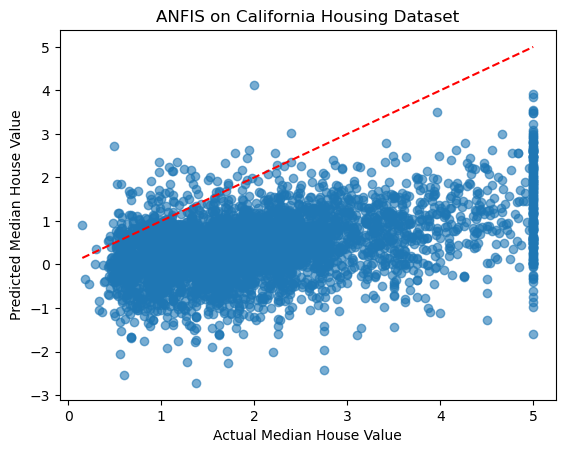

In [5]:
import numpy as np
import itertools
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class MembershipFunction:
    """
    Gaussian membership function:
       μ(x; c, σ) = exp(-0.5 * ((x - c)/σ)^2)
    """
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

    def evaluate(self, x):
        return np.exp(-0.5 * ((x - self.mean) / self.sigma) ** 2)

    def update_parameters(self, d_mean, d_sigma, lr):
        self.mean -= lr * d_mean
        self.sigma -= lr * d_sigma

class ANFIS:
    def __init__(self, n_inputs, n_mfs):
        """
        n_inputs: number of input features.
        n_mfs: number of membership functions per input.
        """
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        
        # Initialize membership functions for each input.
        self.mfs = []
        for i in range(n_inputs):
            mfs_for_input = [MembershipFunction(mean=np.random.uniform(0, 1),
                                                sigma=np.random.uniform(0.1, 1))
                             for _ in range(n_mfs)]
            self.mfs.append(mfs_for_input)
        
        # Create rule base: each rule is a combination of one MF per input.
        self.rules = list(itertools.product(range(n_mfs), repeat=n_inputs))
        self.n_rules = len(self.rules)
        
        # Initialize consequent parameters for each rule.
        # Each consequent is a linear function: f = p1*x1 + ... + pn*xn + r.
        self.consequents = np.random.rand(self.n_rules, n_inputs + 1)

    def forward(self, X):
        n_samples = X.shape[0]
        
        # Layer 1: Evaluate membership functions.
        mf_outputs = []
        for i in range(self.n_inputs):
            x = X[:, i]
            outputs = np.zeros((n_samples, self.n_mfs))
            for j in range(self.n_mfs):
                outputs[:, j] = self.mfs[i][j].evaluate(x)
            mf_outputs.append(outputs)
        
        # Layer 2: Compute firing strengths for each rule.
        firing_strengths = np.zeros((n_samples, self.n_rules))
        for r, rule in enumerate(self.rules):
            prod = np.ones(n_samples)
            for i, mf_index in enumerate(rule):
                prod *= mf_outputs[i][:, mf_index]
            firing_strengths[:, r] = prod
        
        # Layer 3: Normalize the firing strengths.
        sum_fs = np.sum(firing_strengths, axis=1, keepdims=True)
        normalized_fs = firing_strengths / (sum_fs + 1e-6)
        
        # Layer 4: Compute each rule's output.
        # Augment input with a bias term.
        X_aug = np.hstack((X, np.ones((n_samples, 1))))
        rule_outputs = np.zeros((n_samples, self.n_rules))
        for r in range(self.n_rules):
            params = self.consequents[r]
            # Alternatively: np.dot(X_aug, params)
            rule_outputs[:, r] = np.dot(X, params[:-1]) + params[-1]
        
        # Layer 5: Aggregate rule outputs weighted by normalized firing strengths.
        output = np.sum(normalized_fs * rule_outputs, axis=1)
        return output, firing_strengths, normalized_fs, rule_outputs

    def train(self, X, y, epochs=50, lr=0.01):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            # Forward pass.
            output, firing_strengths, normalized_fs, rule_outputs = self.forward(X)
            
            # Compute error and MSE.
            error = y - output
            mse = np.mean(error ** 2)
            print(f"Epoch {epoch+1}/{epochs}, MSE: {mse:.4f}")
            
            # Update consequent parameters using gradient descent.
            # Gradient for each rule's consequent parameters.
            for r in range(self.n_rules):
                grad = -2 * normalized_fs[:, r][:, None] * error[:, None] * np.hstack((X, np.ones((n_samples, 1))))
                grad_mean = np.mean(grad, axis=0)
                self.consequents[r] -= lr * grad_mean
            
            # Note: Updating the membership function parameters (premise) is not implemented here.
        print("Training complete.")

    def predict(self, X):
        output, *_ = self.forward(X)
        return output

if __name__ == "__main__":
    # Load California Housing dataset.
    data = fetch_california_housing()
    X = data.data    # shape: (n_samples, 8)
    y = data.target  # shape: (n_samples,)
    
    # Normalize input features.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Create the ANFIS model.
    anfis_model = ANFIS(n_inputs=X_train.shape[1], n_mfs=3)
    
    # Train the model.
    anfis_model.train(X_train, y_train, epochs=50, lr=0.01)
    
    # Evaluate the model.
    y_train_pred = anfis_model.predict(X_train)
    y_test_pred = anfis_model.predict(X_test)
    
    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)
    
    print(f"\nFinal Training MSE: {train_mse:.4f}")
    print(f"Final Testing MSE: {test_mse:.4f}")
    
    # Plot Actual vs. Predicted for the test set.
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.xlabel("Actual Median House Value")
    plt.ylabel("Predicted Median House Value")
    plt.title("ANFIS on California Housing Dataset")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.show()


ANFIS Epoch 1/50, MSE: 4.0220
ANFIS Epoch 2/50, MSE: 4.0216
ANFIS Epoch 3/50, MSE: 4.0211
ANFIS Epoch 4/50, MSE: 4.0207
ANFIS Epoch 5/50, MSE: 4.0203
ANFIS Epoch 6/50, MSE: 4.0199
ANFIS Epoch 7/50, MSE: 4.0194
ANFIS Epoch 8/50, MSE: 4.0190
ANFIS Epoch 9/50, MSE: 4.0186
ANFIS Epoch 10/50, MSE: 4.0182
ANFIS Epoch 11/50, MSE: 4.0177
ANFIS Epoch 12/50, MSE: 4.0173
ANFIS Epoch 13/50, MSE: 4.0169
ANFIS Epoch 14/50, MSE: 4.0165
ANFIS Epoch 15/50, MSE: 4.0161
ANFIS Epoch 16/50, MSE: 4.0156
ANFIS Epoch 17/50, MSE: 4.0152
ANFIS Epoch 18/50, MSE: 4.0148
ANFIS Epoch 19/50, MSE: 4.0144
ANFIS Epoch 20/50, MSE: 4.0139
ANFIS Epoch 21/50, MSE: 4.0135
ANFIS Epoch 22/50, MSE: 4.0131
ANFIS Epoch 23/50, MSE: 4.0127
ANFIS Epoch 24/50, MSE: 4.0123
ANFIS Epoch 25/50, MSE: 4.0118
ANFIS Epoch 26/50, MSE: 4.0114
ANFIS Epoch 27/50, MSE: 4.0110
ANFIS Epoch 28/50, MSE: 4.0106
ANFIS Epoch 29/50, MSE: 4.0101
ANFIS Epoch 30/50, MSE: 4.0097
ANFIS Epoch 31/50, MSE: 4.0093
ANFIS Epoch 32/50, MSE: 4.0089
ANFIS Epoch 33/50

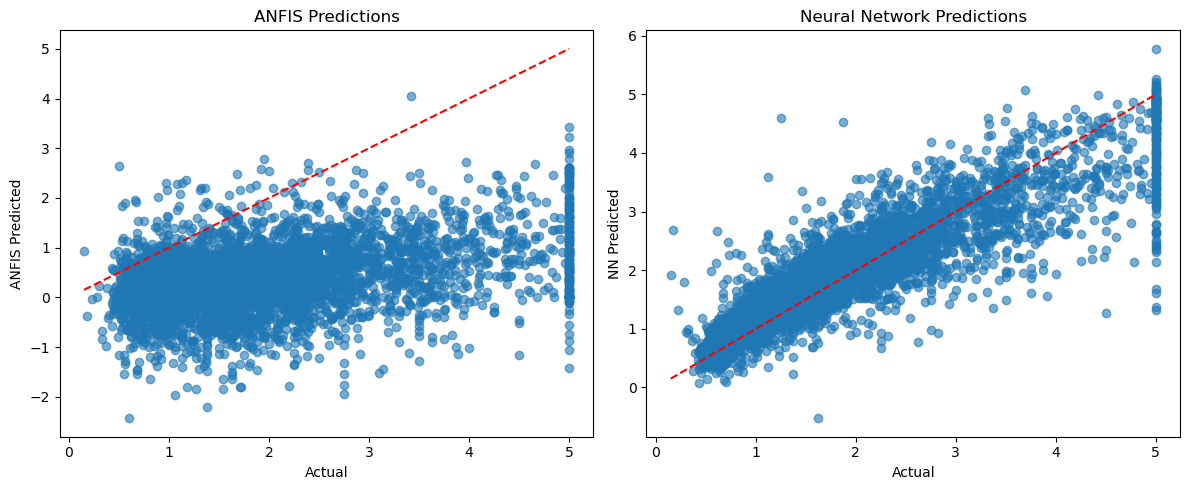

In [6]:
import numpy as np
import itertools
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# -------------------------------
# ANFIS Implementation
# -------------------------------

class MembershipFunction:
    """
    Gaussian membership function:
       μ(x; c, σ) = exp(-0.5 * ((x - c)/σ)^2)
    """
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

    def evaluate(self, x):
        return np.exp(-0.5 * ((x - self.mean) / self.sigma) ** 2)

    def update_parameters(self, d_mean, d_sigma, lr):
        self.mean -= lr * d_mean
        self.sigma -= lr * d_sigma

class ANFIS:
    def __init__(self, n_inputs, n_mfs):
        """
        n_inputs: number of input features.
        n_mfs: number of membership functions per input.
        """
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        
        # Initialize membership functions for each input.
        self.mfs = []
        for i in range(n_inputs):
            mfs_for_input = [MembershipFunction(mean=np.random.uniform(0, 1),
                                                sigma=np.random.uniform(0.1, 1))
                             for _ in range(n_mfs)]
            self.mfs.append(mfs_for_input)
        
        # Create rule base: each rule is a combination of one membership function per input.
        self.rules = list(itertools.product(range(n_mfs), repeat=n_inputs))
        self.n_rules = len(self.rules)
        
        # Initialize consequent parameters for each rule.
        # Each consequent is a linear function: f = p1*x1 + p2*x2 + ... + pn*xn + r.
        self.consequents = np.random.rand(self.n_rules, n_inputs + 1)

    def forward(self, X):
        n_samples = X.shape[0]
        
        # Layer 1: Evaluate membership functions.
        mf_outputs = []
        for i in range(self.n_inputs):
            x = X[:, i]
            outputs = np.zeros((n_samples, self.n_mfs))
            for j in range(self.n_mfs):
                outputs[:, j] = self.mfs[i][j].evaluate(x)
            mf_outputs.append(outputs)
        
        # Layer 2: Compute firing strengths for each rule.
        firing_strengths = np.zeros((n_samples, self.n_rules))
        for r, rule in enumerate(self.rules):
            prod = np.ones(n_samples)
            for i, mf_index in enumerate(rule):
                prod *= mf_outputs[i][:, mf_index]
            firing_strengths[:, r] = prod
        
        # Layer 3: Normalize the firing strengths.
        sum_fs = np.sum(firing_strengths, axis=1, keepdims=True)
        normalized_fs = firing_strengths / (sum_fs + 1e-6)
        
        # Layer 4: Compute each rule's output.
        # Augment input with a bias term.
        X_aug = np.hstack((X, np.ones((n_samples, 1))))
        rule_outputs = np.zeros((n_samples, self.n_rules))
        for r in range(self.n_rules):
            params = self.consequents[r]
            rule_outputs[:, r] = np.dot(X, params[:-1]) + params[-1]
        
        # Layer 5: Aggregate rule outputs weighted by normalized firing strengths.
        output = np.sum(normalized_fs * rule_outputs, axis=1)
        return output, firing_strengths, normalized_fs, rule_outputs

    def train(self, X, y, epochs=50, lr=0.01):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            output, firing_strengths, normalized_fs, rule_outputs = self.forward(X)
            
            # Compute error and mean squared error (MSE).
            error = y - output
            mse = np.mean(error ** 2)
            print(f"ANFIS Epoch {epoch+1}/{epochs}, MSE: {mse:.4f}")
            
            # Update consequent parameters using gradient descent.
            for r in range(self.n_rules):
                grad = -2 * normalized_fs[:, r][:, None] * error[:, None] * np.hstack((X, np.ones((n_samples, 1))))
                grad_mean = np.mean(grad, axis=0)
                self.consequents[r] -= lr * grad_mean
            
            # (Premise parameters update is not implemented here.)
        print("ANFIS training complete.")

    def predict(self, X):
        output, *_ = self.forward(X)
        return output

# -------------------------------
# Data Preparation
# -------------------------------

# Load California Housing dataset.
data = fetch_california_housing()
X = data.data      # Features shape: (n_samples, 8)
y = data.target    # Targets shape: (n_samples,)

# Scale features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# -------------------------------
# Train ANFIS Model
# -------------------------------

anfis_model = ANFIS(n_inputs=X_train.shape[1], n_mfs=3)
anfis_model.train(X_train, y_train, epochs=50, lr=0.01)

# Evaluate ANFIS.
y_train_pred_anfis = anfis_model.predict(X_train)
y_test_pred_anfis = anfis_model.predict(X_test)
train_mse_anfis = np.mean((y_train - y_train_pred_anfis) ** 2)
test_mse_anfis = np.mean((y_test - y_test_pred_anfis) ** 2)
print(f"\nANFIS - Training MSE: {train_mse_anfis:.4f}")
print(f"ANFIS - Testing MSE: {test_mse_anfis:.4f}")

# -------------------------------
# Train Simple Neural Network
# -------------------------------

# Create a simple neural network with one hidden layer of 50 neurons.
mlp = MLPRegressor(hidden_layer_sizes=(50,), activation='relu',
                   solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Evaluate Neural Network.
y_train_pred_nn = mlp.predict(X_train)
y_test_pred_nn = mlp.predict(X_test)
train_mse_nn = np.mean((y_train - y_train_pred_nn) ** 2)
test_mse_nn = np.mean((y_test - y_test_pred_nn) ** 2)
print(f"\nNeural Network - Training MSE: {train_mse_nn:.4f}")
print(f"Neural Network - Testing MSE: {test_mse_nn:.4f}")

# -------------------------------
# Plot Predictions Comparison
# -------------------------------

plt.figure(figsize=(12, 5))

# ANFIS predictions plot.
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_anfis, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("ANFIS Predicted")
plt.title("ANFIS Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

# Neural Network predictions plot.
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_nn, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("NN Predicted")
plt.title("Neural Network Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import itertools
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -------------------------------
# Updated ANFIS Implementation with Premise Updates
# -------------------------------

class MembershipFunction:
    """
    Gaussian membership function:
       μ(x; c, σ) = exp(-0.5 * ((x - c)/σ)^2)
    """
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

    def evaluate(self, x):
        return np.exp(-0.5 * ((x - self.mean) / self.sigma) ** 2)

class ANFIS:
    def __init__(self, n_inputs, n_mfs):
        """
        n_inputs: number of input features.
        n_mfs: number of membership functions per input.
        """
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        
        # Initialize membership functions for each input.
        self.mfs = []
        for i in range(n_inputs):
            mfs_for_input = [MembershipFunction(mean=np.random.uniform(0, 1),
                                                sigma=np.random.uniform(0.1, 1))
                             for _ in range(n_mfs)]
            self.mfs.append(mfs_for_input)
        
        # Create rule base: each rule is a combination of one membership function per input.
        self.rules = list(itertools.product(range(n_mfs), repeat=n_inputs))
        self.n_rules = len(self.rules)
        
        # Initialize consequent parameters for each rule.
        # Each consequent is a linear function: f = p1*x1 + ... + pn*xn + r.
        self.consequents = np.random.rand(self.n_rules, n_inputs + 1)

    def forward(self, X):
        n_samples = X.shape[0]
        
        # Layer 1: Evaluate membership functions for each input.
        # mf_outputs is a list (one per input) of shape (n_samples, n_mfs)
        mf_outputs = []
        for i in range(self.n_inputs):
            x = X[:, i]
            outputs = np.zeros((n_samples, self.n_mfs))
            for j in range(self.n_mfs):
                outputs[:, j] = self.mfs[i][j].evaluate(x)
            mf_outputs.append(outputs)
        
        # Layer 2: Compute firing strengths for each rule.
        firing_strengths = np.zeros((n_samples, self.n_rules))
        for r, rule in enumerate(self.rules):
            prod = np.ones(n_samples)
            for i, mf_index in enumerate(rule):
                prod *= mf_outputs[i][:, mf_index]
            firing_strengths[:, r] = prod
        
        # Layer 3: Normalize the firing strengths.
        sum_fs = np.sum(firing_strengths, axis=1, keepdims=True)
        normalized_fs = firing_strengths / (sum_fs + 1e-6)
        
        # Layer 4: Compute each rule's output.
        # Augment input with a bias term.
        X_aug = np.hstack((X, np.ones((n_samples, 1))))
        rule_outputs = np.zeros((n_samples, self.n_rules))
        for r in range(self.n_rules):
            params = self.consequents[r]
            rule_outputs[:, r] = np.dot(X, params[:-1]) + params[-1]
        
        # Layer 5: Aggregate rule outputs weighted by normalized firing strengths.
        output = np.sum(normalized_fs * rule_outputs, axis=1)
        
        # Return additional quantities for gradient calculations.
        return output, firing_strengths, normalized_fs, rule_outputs, mf_outputs

    def train(self, X, y, epochs=50, lr=0.01):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            # Forward pass.
            output, firing_strengths, normalized_fs, rule_outputs, mf_outputs = self.forward(X)
            
            # Compute error and mean squared error (MSE).
            error = y - output
            mse = np.mean(error ** 2)
            print(f"Epoch {epoch+1}/{epochs}, MSE: {mse:.4f}")
            
            # ----- Update Consequent Parameters -----
            # For each rule, update the consequent parameters.
            X_aug = np.hstack((X, np.ones((n_samples, 1))))
            for r in range(self.n_rules):
                grad = -2 * normalized_fs[:, r][:, None] * error[:, None] * X_aug
                grad_mean = np.mean(grad, axis=0)
                self.consequents[r] -= lr * grad_mean

            # ----- Update Premise Parameters (Membership Functions) -----
            # For each input dimension and each membership function, update its parameters.
            for d in range(self.n_inputs):
                for j in range(self.n_mfs):
                    grad_c = 0.0
                    grad_sigma = 0.0
                    # Identify rules that use the j-th MF for input d.
                    relevant_rules = [r for r in range(self.n_rules) if self.rules[r][d] == j]
                    
                    for i in range(n_samples):
                        # Sum of firing strengths for sample i.
                        S_val = np.sum(firing_strengths[i, :])
                        for r in relevant_rules:
                            mu_val = mf_outputs[d][i, j]
                            # Avoid division by zero.
                            if mu_val < 1e-6:
                                continue
                            # Derivative of firing strength for rule r w.r.t. mu for this MF.
                            d_omega = firing_strengths[i, r] / mu_val
                            
                            # Sum of derivatives for all rules that use this MF.
                            sum_dS = 0.0
                            for r2 in relevant_rules:
                                sum_dS += firing_strengths[i, r2] / (mf_outputs[d][i, j] + 1e-6)
                            
                            # Derivative of normalized firing strength:
                            d_bar = (S_val * d_omega - firing_strengths[i, r] * sum_dS) / ((S_val**2) + 1e-6)
                            
                            # Contribution to derivative of output.
                            d_output_mu = d_bar * rule_outputs[i, r]
                            # Chain rule: derivative of error w.r.t. mu.
                            dE_dmu = -2 * (y[i] - output[i]) * d_output_mu
                            
                            # Derivatives of the Gaussian membership function.
                            # μ(x; c, σ) = exp(-0.5 * ((x - c)/σ)^2)
                            # dμ/dc = μ * (x - c) / σ^2
                            # dμ/dσ = μ * ((x - c)^2) / σ^3
                            x_val = X[i, d]
                            c_val = self.mfs[d][j].mean
                            sigma_val = self.mfs[d][j].sigma
                            
                            d_mu_dc = mu_val * (x_val - c_val) / (sigma_val**2 + 1e-6)
                            d_mu_dsigma = mu_val * ((x_val - c_val)**2) / (sigma_val**3 + 1e-6)
                            
                            grad_c += dE_dmu * d_mu_dc
                            grad_sigma += dE_dmu * d_mu_dsigma
                    
                    # Average the gradient over all samples.
                    grad_c /= n_samples
                    grad_sigma /= n_samples
                    # Update parameters.
                    self.mfs[d][j].mean -= lr * grad_c
                    new_sigma = self.mfs[d][j].sigma - lr * grad_sigma
                    # Ensure sigma remains positive.
                    self.mfs[d][j].sigma = max(new_sigma, 1e-3)
            
        print("Training complete.")

    def predict(self, X):
        output, *_ = self.forward(X)
        return output

# -------------------------------
# Data Preparation and Training
# -------------------------------

# Load California Housing dataset.
data = fetch_california_housing()
X = data.data      # Features shape: (n_samples, 8)
y = data.target    # Targets shape: (n_samples,)

# Scale features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the ANFIS model.
anfis_model = ANFIS(n_inputs=X_train.shape[1], n_mfs=3)

# Train the model.
anfis_model.train(X_train, y_train, epochs=1, lr=0.01)

# Evaluate the model.
y_train_pred = anfis_model.predict(X_train)
y_test_pred = anfis_model.predict(X_test)
train_mse = np.mean((y_train - y_train_pred) ** 2)
test_mse = np.mean((y_test - y_test_pred) ** 2)

print(f"\nFinal Training MSE: {train_mse:.4f}")
print(f"Final Testing MSE: {test_mse:.4f}")

# Plot Actual vs. Predicted for the test set.
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("ANFIS (with Premise Updates) on California Housing Dataset")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()


Epoch 1/1, MSE: 4.1694
